In [35]:
# N-Gram und Masked Language Modeling für Liedtextanalyse
# Basierend auf den Konzepten aus Lecture 6: Language Models

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import nltk
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import re
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM
from tqdm import tqdm
import math
import random
import warnings
warnings.filterwarnings('ignore')

# NLTK für Tokenisierung herunterladen
try:
    nltk.download('punkt', quiet=True)
except:
    print("NLTK Punkt konnte nicht heruntergeladen werden. Fallback-Methode wird verwendet.")

# Dateipfad
file_path = '/Users/lucaschambeck/Library/CloudStorage/OneDrive-ZHAW/Studium/Semester 4/PM4/PM4_Lyrics/data/reduced/lyrics_minimal.csv'

# Daten einlesen
print("Lade Datensatz...")
df = pd.read_csv(file_path)
print(f"Datensatz geladen: {df.shape[0]} Zeilen und {df.shape[1]} Spalten")

Lade Datensatz...
Datensatz geladen: 500 Zeilen und 11 Spalten


In [36]:
# 1. Datenvorverarbeitung
# ----------------------

# Funktion zur Textbereinigung
def clean_text(text):
    if pd.isna(text):
        return ""
    # Text in Kleinbuchstaben umwandeln und gewisse Sonderzeichen behalten
    text = str(text).lower().strip()
    # Entferne spezielle Zeichen, behalte aber Apostrophe und Bindestriche
    text = re.sub(r'[^\w\s\'-]', ' ', text)
    # Ersetze mehrfache Leerzeichen durch ein einzelnes
    text = re.sub(r'\s+', ' ', text)
    return text

# Tokenisierungsfunktion
def tokenize_text(text):
    if pd.isna(text):
        return []
    # Bereinige Text
    text = clean_text(text)
    if not text:
        return []
    
    # Tokenisiere mit NLTK, wenn verfügbar
    try:
        tokens = word_tokenize(text)
    except:
        # Fallback: einfache Trennung nach Leerzeichen
        tokens = text.split()
    
    return tokens

# Anwenden der Textbereinigung und Tokenisierung
print("Verarbeite Liedtexte...")
df['cleaned_lyrics'] = df['lyrics'].apply(clean_text)
df['tokens'] = df['cleaned_lyrics'].apply(tokenize_text)

# Filtern nach Sprache (beschränke auf eine Sprache, z.B. Englisch)
english_df = df[df['language'] == 'en'].copy()
print(f"Englische Texte: {len(english_df)}")

Verarbeite Liedtexte...
Englische Texte: 100


In [37]:
# 2. N-Gram Language Model
# -----------------------

class NGramModel:
    def __init__(self, n=2):
        """
        Initialisiert ein n-Gram Sprachmodell.
        
        Args:
            n: Die Größe der n-Grams (2 für Bi-Grams, 3 für Tri-Grams, etc.)
        """
        self.n = n
        self.ngram_counts = defaultdict(Counter)
        self.context_counts = defaultdict(int)
        self.vocabulary = set()
        
    def fit(self, token_sequences):
        """
        Trainiert das n-Gram Modell auf einer Liste von Token-Sequenzen.
        
        Args:
            token_sequences: Liste von Listen von Tokens
        """
        print(f"Trainiere {self.n}-Gram Modell...")
        
        for tokens in tqdm(token_sequences):
            # Füge Anfangs- und Ende-Marker hinzu
            tokens = ['<s>'] * (self.n - 1) + tokens + ['</s>']
            
            # Erweitere das Vokabular
            self.vocabulary.update(tokens)
            
            # Erzeuge n-Grams und zähle sie
            for i in range(len(tokens) - self.n + 1):
                ngram = tuple(tokens[i:i+self.n])
                context = ngram[:-1]
                word = ngram[-1]
                
                self.ngram_counts[context][word] += 1
                self.context_counts[context] += 1
        
        print(f"Modell trainiert mit {len(self.ngram_counts)} Kontexten und {len(self.vocabulary)} Vokabeln.")
    
    def probability(self, word, context):
        """
        Berechnet die Wahrscheinlichkeit P(word|context) basierend auf dem n-Gram Modell.
        
        Args:
            word: Das Wort, dessen Wahrscheinlichkeit berechnet werden soll
            context: Der Kontext (n-1 vorhergehende Wörter als Tuple)
            
        Returns:
            Die Wahrscheinlichkeit des Wortes gegeben den Kontext
        """
        if context in self.context_counts:
            return self.ngram_counts[context][word] / self.context_counts[context]
        return 0
    
    def sequence_probability(self, tokens):
        """
        Berechnet die Log-Wahrscheinlichkeit einer Sequenz von Tokens.
        
        Args:
            tokens: Liste von Tokens
            
        Returns:
            Log-Wahrscheinlichkeit der Sequenz
        """
        # Füge Anfangs- und Ende-Marker hinzu
        tokens = ['<s>'] * (self.n - 1) + tokens + ['</s>']
        
        log_prob = 0
        for i in range(len(tokens) - self.n + 1):
            context = tuple(tokens[i:i+self.n-1])
            word = tokens[i+self.n-1]
            
            prob = self.probability(word, context)
            # Verwende Laplace-Smoothing für 0-Wahrscheinlichkeiten
            if prob == 0:
                prob = 1 / (self.context_counts[context] + len(self.vocabulary))
            
            log_prob += math.log(prob)
        
        return log_prob
    
    def generate_text(self, length=20, seed=None):
        """
        Generiert Text mit dem n-Gram Modell.
        
        Args:
            length: Die Anzahl der zu generierenden Tokens
            seed: Optionaler Startkontext
            
        Returns:
            Eine Liste von generierten Tokens
        """
        if seed is None:
            # Beginne mit Start-Markern
            generated = ['<s>'] * (self.n - 1)
        else:
            generated = seed
            
            # Stelle sicher, dass der Seed die richtige Länge hat
            if len(generated) < self.n - 1:
                generated = ['<s>'] * (self.n - 1 - len(generated)) + generated
            elif len(generated) > self.n - 1:
                generated = generated[-(self.n-1):]
        
        # Generiere Tokens
        for _ in range(length):
            context = tuple(generated[-(self.n-1):])
            
            # Wenn der Kontext unbekannt ist, wähle zufällig
            if context not in self.context_counts or self.context_counts[context] == 0:
                next_word = random.choice(list(self.vocabulary - {'<s>', '</s>'}))
            else:
                # Wähle das nächste Wort basierend auf der Verteilung
                candidates = self.ngram_counts[context].most_common()
                total = self.context_counts[context]
                r = random.random() * total
                cumulative = 0
                
                for word, count in candidates:
                    cumulative += count
                    if cumulative >= r:
                        next_word = word
                        break
                else:
                    # Fallback, falls etwas schief geht
                    next_word = candidates[0][0] if candidates else random.choice(list(self.vocabulary))
            
            generated.append(next_word)
            
            # Beende, wenn das Ende-Token erreicht wird
            if next_word == '</s>':
                break
        
        # Entferne Start- und Ende-Marker
        return [token for token in generated if token not in ['<s>', '</s>']]
    
    def perplexity(self, token_sequences):
        """
        Berechnet die Perplexität des Modells auf einem Testset.
        
        Args:
            token_sequences: Liste von Listen von Tokens
            
        Returns:
            Die Perplexität des Modells auf den Daten
        """
        log_prob_sum = 0
        token_count = 0
        
        for tokens in token_sequences:
            if not tokens:
                continue
                
            log_prob = self.sequence_probability(tokens)
            log_prob_sum += log_prob
            token_count += len(tokens) + 1  # +1 für das Ende-Token
        
        # Berechne die durchschnittliche Log-Wahrscheinlichkeit pro Token
        avg_log_prob = log_prob_sum / token_count
        
        # Perplexität ist 2^(-avg_log_prob)
        return math.exp(-avg_log_prob)
    
    def find_most_likely_next_words(self, context, k=5):
        """
        Findet die k wahrscheinlichsten nächsten Wörter für einen gegebenen Kontext.
        
        Args:
            context: Liste von Tokens als Kontext
            k: Anzahl der zurückzugebenden Wörter
            
        Returns:
            Liste von (Wort, Wahrscheinlichkeit) Paaren
        """
        if len(context) < self.n - 1:
            context = ['<s>'] * (self.n - 1 - len(context)) + context
        elif len(context) > self.n - 1:
            context = context[-(self.n-1):]
        
        context_tuple = tuple(context)
        
        if context_tuple not in self.context_counts:
            return [("_UNK_", 1.0)]
        
        # Hole die Zählungen für den Kontext
        word_counts = self.ngram_counts[context_tuple]
        total_count = self.context_counts[context_tuple]
        
        # Berechne die Wahrscheinlichkeiten
        word_probs = [(word, count / total_count) for word, count in word_counts.items()]
        
        # Sortiere nach Wahrscheinlichkeit und gib die Top-k zurück
        return sorted(word_probs, key=lambda x: x[1], reverse=True)[:k]

In [38]:
# 3. Masked Language Modeling mit Transformer-basierten Modellen
# ------------------------------------------------------------

class MaskedLanguageModelAnalyzer:
    def __init__(self, model_name="distilbert-base-uncased"):
        """
        Initialisiert einen Analyzer für Masked Language Modeling.
        
        Args:
            model_name: Name des vortrainierten Modells
        """
        print(f"Initialisiere Masked Language Model mit {model_name}...")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForMaskedLM.from_pretrained(model_name)
        self.model.eval()  # Setze das Modell in den Evaluierungsmodus
        
        # Prüfe, ob CUDA verfügbar ist
        self.device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
        self.model.to(self.device)
        
        # Token-IDs für spezielle Tokens
        self.mask_token_id = self.tokenizer.mask_token_id
        self.mask_token = self.tokenizer.mask_token
    
    def predict_masked_token(self, text, k=5):
        """
        Sagt die k wahrscheinlichsten Tokens an der maskierten Position voraus.
        
        Args:
            text: Text mit einem maskierten Token ([MASK])
            k: Anzahl der zurückzugebenden Token-Vorhersagen
            
        Returns:
            Liste von (Token, Wahrscheinlichkeit) Paaren
        """
        # Tokenisiere den Text
        inputs = self.tokenizer(text, return_tensors="pt")
        inputs = {key: val.to(self.device) for key, val in inputs.items()}
        
        # Finde die Position des maskierten Tokens
        mask_positions = (inputs["input_ids"] == self.mask_token_id).nonzero(as_tuple=True)[1]
        
        if len(mask_positions) == 0:
            return [("_NO_MASK_", 1.0)]
        
        # Führe die Vorhersage durch
        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits
        
        # Nehme die Logits an der maskierten Position
        mask_position = mask_positions[0]
        mask_logits = logits[0, mask_position, :]
        
        # Konvertiere Logits zu Wahrscheinlichkeiten mit Softmax
        probs = torch.nn.functional.softmax(mask_logits, dim=0)
        
        # Hole die Top-k Vorhersagen
        top_k = torch.topk(probs, k)
        
        # Konvertiere zu Token
        tokens = [self.tokenizer.decode([idx]) for idx in top_k.indices]
        probabilities = top_k.values.cpu().numpy()
        
        return list(zip(tokens, probabilities))
    
    def analyze_text_with_masks(self, text, mask_positions=None):
        """
        Analysiert einen Text, indem nacheinander verschiedene Positionen maskiert werden.
        
        Args:
            text: Zu analysierender Text
            mask_positions: Liste von Positionen, die maskiert werden sollen (wenn None, werden alle maskiert)
            
        Returns:
            Dictionary mit Analyse-Ergebnissen
        """
        tokens = word_tokenize(text.lower())
        
        if mask_positions is None:
            # Maskiere jede Position (außer Satzzeichen)
            mask_positions = [i for i, token in enumerate(tokens) if token.isalpha()]
        
        results = []
        
        for pos in mask_positions:
            # Kopiere die Token-Liste und maskiere die aktuelle Position
            masked_tokens = tokens.copy()
            original_token = masked_tokens[pos]
            masked_tokens[pos] = self.mask_token
            
            # Rekonstruiere den Text
            masked_text = ' '.join(masked_tokens)
            
            # Mache die Vorhersage
            predictions = self.predict_masked_token(masked_text, k=5)
            
            results.append({
                'position': pos,
                'original_token': original_token,
                'predictions': predictions,
                'original_is_in_top5': any(p[0].strip() == original_token for p in predictions),
                'top_prediction': predictions[0][0] if predictions else None,
                'top_probability': predictions[0][1] if predictions else 0
            })
        
        return {
            'original_text': text,
            'tokens': tokens,
            'mask_analyses': results
        }
    
    def analyze_predictability(self, text):
        """
        Analysiert die Vorhersagbarkeit eines Textes basierend auf MLM.
        
        Args:
            text: Zu analysierender Text
            
        Returns:
            Dictionary mit Metriken zur Vorhersagbarkeit
        """
        analysis = self.analyze_text_with_masks(text)
        
        # Berechne verschiedene Metriken
        mask_analyses = analysis['mask_analyses']
        total_positions = len(mask_analyses)
        
        if total_positions == 0:
            return {
                'original_text': text,
                'predictability_score': 0,
                'avg_top_probability': 0,
                'original_in_top5_ratio': 0
            }
        
        # Durchschnittliche Wahrscheinlichkeit der Top-Vorhersage
        avg_top_probability = sum(result['top_probability'] for result in mask_analyses) / total_positions
        
        # Anteil der Positionen, bei denen das Original in den Top-5 ist
        original_in_top5_count = sum(1 for result in mask_analyses if result['original_is_in_top5'])
        original_in_top5_ratio = original_in_top5_count / total_positions
        
        # Gesamtvorhersagbarkeit (kombinierte Metrik)
        predictability_score = (avg_top_probability + original_in_top5_ratio) / 2
        
        return {
            'original_text': text,
            'predictability_score': predictability_score,
            'avg_top_probability': avg_top_probability,
            'original_in_top5_ratio': original_in_top5_ratio
        }

In [39]:
# Token-Sequenzen vorbereiten
token_sequences = english_df['tokens'].tolist()
token_sequences = [seq for seq in token_sequences if seq]  # leere rausfiltern

# Optional: Anzahl beschränken
max_sequences = 5000
if len(token_sequences) > max_sequences:
    print(f"Beschränke Training auf {max_sequences} zufällige Sequenzen...")
    random.seed(42)
    token_sequences = random.sample(token_sequences, max_sequences)


In [40]:
# n-Gram Modelle trainieren
bigram_model = NGramModel(n=2)
bigram_model.fit(token_sequences)

trigram_model = NGramModel(n=3)
trigram_model.fit(token_sequences)


Trainiere 2-Gram Modell...


100%|██████████| 100/100 [00:00<00:00, 16496.77it/s]


Modell trainiert mit 2494 Kontexten und 2495 Vokabeln.
Trainiere 3-Gram Modell...


100%|██████████| 100/100 [00:00<00:00, 3048.03it/s]

Modell trainiert mit 7370 Kontexten und 2495 Vokabeln.


In [41]:
test_sequences = token_sequences[-100:]
print("\nBerechne Perplexität der Modelle auf Testdaten...")

bigram_perplexity = bigram_model.perplexity(test_sequences)
trigram_perplexity = trigram_model.perplexity(test_sequences)

print(f"Bi-Gram Perplexität: {bigram_perplexity:.2f}")
print(f"Tri-Gram Perplexität: {trigram_perplexity:.2f}")



Berechne Perplexität der Modelle auf Testdaten...
Bi-Gram Perplexität: 9.39
Tri-Gram Perplexität: 1.48


In [42]:
print("\nGeneriere Beispieltexte mit den n-Gram Modellen:")
for i in range(3):
    bigram_text = ' '.join(bigram_model.generate_text(length=20))
    print(f"Bi-Gram generierter Text {i+1}: {bigram_text}")
    
    trigram_text = ' '.join(trigram_model.generate_text(length=20))
    print(f"Tri-Gram generierter Text {i+1}: {trigram_text}")



Generiere Beispieltexte mit den n-Gram Modellen:
Bi-Gram generierter Text 1: verse 1 c-murder i'm darth maul playin hardball over it feels real but a couple bodies chopped up yo stash
Tri-Gram generierter Text 1: noreaga - talking lets keep it grimy get with that plastic on your head up oahh-eahh-oh-ahh oahh-eahh-oh-ahh guru yo just
Bi-Gram generierter Text 2: dr dooom jacky you nam'sayin sometimes i can tighten your mask let me yeah the block little microscopic pieces niggas
Tri-Gram generierter Text 2: ese daz orale ese pull the trigger and bust a vietnam we droppin' bomb shit strapped do draw ready to
Bi-Gram generierter Text 3: intro stic man pimp c
Tri-Gram generierter Text 3: verse 1 2d i'm walking to the chi i ain't got a fuckin nest now listen to my nerd-ery soon


In [43]:
bigram_contexts = sorted(bigram_model.context_counts.items(), key=lambda x: x[1], reverse=True)
print("\nTop-10 häufigste Uni-Gram Kontexte und ihre wahrscheinlichsten Folgewörter:")
for i, (context, count) in enumerate(bigram_contexts[:10]):
    next_words = bigram_model.find_most_likely_next_words(list(context), k=3)
    next_words_str = ', '.join([f"{word} ({prob:.2f})" for word, prob in next_words])
    print(f"{i+1}. Kontext: '{context[0]}' (Häufigkeit: {count}) → {next_words_str}")



Top-10 häufigste Uni-Gram Kontexte und ihre wahrscheinlichsten Folgewörter:
1. Kontext: 'the' (Häufigkeit: 400) → shit (0.01), </s> (0.01), house (0.01)
2. Kontext: 'i' (Häufigkeit: 237) → was (0.06), don't (0.05), know (0.05)
3. Kontext: 'to' (Häufigkeit: 197) → the (0.13), my (0.06), do (0.04)
4. Kontext: 'a' (Häufigkeit: 192) → nigga (0.04), lazy (0.04), little (0.03)
5. Kontext: 'and' (Häufigkeit: 173) → the (0.08), i (0.06), my (0.04)
6. Kontext: 'you' (Häufigkeit: 167) → know (0.15), don't (0.04), got (0.04)
7. Kontext: 'in' (Häufigkeit: 151) → the (0.42), my (0.10), this (0.07)
8. Kontext: 'it' (Häufigkeit: 147) → up (0.10), out (0.08), don't (0.04)
9. Kontext: 'my' (Häufigkeit: 128) → nigga (0.06), dick (0.04), man (0.04)
10. Kontext: 'i'm' (Häufigkeit: 101) → ill (0.11), in (0.05), here (0.03)


In [44]:
trigram_contexts = sorted(trigram_model.context_counts.items(), key=lambda x: x[1], reverse=True)
print("\nTop-10 häufigste Bi-Gram Kontexte und ihre wahrscheinlichsten Folgewörter:")
for i, (context, count) in enumerate(trigram_contexts[:10]):
    next_words = trigram_model.find_most_likely_next_words(list(context), k=3)
    next_words_str = ', '.join([f"{word} ({prob:.2f})" for word, prob in next_words])
    print(f"{i+1}. Kontext: '{context[0]} {context[1]}' (Häufigkeit: {count}) → {next_words_str}")



Top-10 häufigste Bi-Gram Kontexte und ihre wahrscheinlichsten Folgewörter:
1. Kontext: '<s> <s>' (Häufigkeit: 100) → intro (0.41), verse (0.10), hook (0.06)
2. Kontext: 'in the' (Häufigkeit: 63) → house (0.08), dough (0.05), benz (0.03)
3. Kontext: 'verse 1' (Häufigkeit: 54) → some (0.02), erick (0.02), yo (0.02)
4. Kontext: '<s> intro' (Häufigkeit: 41) → yeah (0.07), hey (0.05), uhhh (0.02)
5. Kontext: 'blah blah' (Häufigkeit: 36) → blah (0.78), collapse (0.08), fall (0.03)
6. Kontext: 'to the' (Häufigkeit: 26) → essence (0.04), others (0.04), worst (0.04)
7. Kontext: 'you know' (Häufigkeit: 25) → i (0.20), daddy's (0.16), what (0.12)
8. Kontext: 'on the' (Häufigkeit: 16) → dizzough (0.06), average (0.06), yellow (0.06)
9. Kontext: 'i've been' (Häufigkeit: 16) → a (0.12), there (0.12), up (0.06)
10. Kontext: 'in my' (Häufigkeit: 15) → heart (0.07), slang (0.07), ship (0.07)


In [45]:
mlm_analyzer = MaskedLanguageModelAnalyzer()
print("\nMasked Language Model Analyzer initialisiert.")


Initialisiere Masked Language Model mit distilbert-base-uncased...

Masked Language Model Analyzer initialisiert.


In [50]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/lucaschambeck/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [51]:
import nltk
import random
from nltk.tokenize import word_tokenize

# Download necessary data
nltk.download('punkt')

# Sample songs from your dataframe
sample_songs = english_df.sample(5)
for _, song in sample_songs.iterrows():
    try:
        title = song['title']
        artist = song['artist']
        lyrics = song['cleaned_lyrics']
        
        # Filter for substantial lines
        lines = [line.strip() for line in lyrics.split('\n') if len(line.strip()) > 20]
        if not lines:
            print(f"Überspringe '{title}' von {artist} (keine geeigneten Zeilen)")
            continue
        
        sample_line = random.choice(lines)
        print(f"\nSong: '{title}' von {artist}")
        print(f"Beispielzeile: \"{sample_line}\"")
        
        # Calculate predictability score
        try:
            predictability = mlm_analyzer.analyze_predictability(sample_line)
            print(f"Vorhersagbarkeits-Score: {predictability['predictability_score']:.3f}")
        except Exception as e:
            print(f"Fehler bei der Vorhersagbarkeitsanalyse: {e}")
            continue
        
        # Mask a word in the middle and show predictions
        tokens = word_tokenize(sample_line.lower())
        if len(tokens) > 3:
            pos = len(tokens) // 2
            if tokens[pos].isalpha():
                masked_tokens = tokens.copy()
                original_token = masked_tokens[pos]
                masked_tokens[pos] = mlm_analyzer.mask_token
                masked_text = ' '.join(masked_tokens)
                print(f"\nBeispiel-Maskierung: \"{masked_text}\"")
                print(f"Original-Wort: \"{original_token}\"")
                
                try:
                    predictions = mlm_analyzer.predict_masked_token(masked_text, k=5)
                    for i, (token, prob) in enumerate(predictions):
                        print(f"  {i+1}. \"{token}\" ({prob:.3f})")
                except Exception as e:
                    print(f"Fehler bei der Token-Vorhersage: {e}")
            else:
                print("Mittleres Token ist kein alphabetisches Wort, überspringe Maskierung")
    except Exception as e:
        print(f"Fehler bei der Verarbeitung eines Songs: {e}")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lucaschambeck/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Song: 'Depend on Me' von Mr. Magic
Beispielzeile: "c-murder this for all my real niggas locked up payin they dues doin that time you know don't trip chorus c-murder i be's a tru nigga till i'm dead depend on me i won't rest till all my thug niggas is free x2 verse 1 c-murder i'm in the studio smokin weed with my tru thugs motherfuckers gettin' high pass another dub a whole room full of gangstas with tru tats million dollar niggas still wearin' them baseball caps and never amongst no fake ass motherfuckers we posse up and j"
Vorhersagbarkeits-Score: 0.273
Mittleres Token ist kein alphabetisches Wort, überspringe Maskierung

Song: 'Hypnotic' von Syleena Johnson
Beispielzeile: "intro - r kelly - talking uh uh uh y'all know what this is uh so bob your heads yeah ladies it's your boyfriend and uh miss johnson yeah woo we mixin drinks right now y'all syleena johnson your love is so verse 1 - r kelly i step up in the spot and all the heads turn turn pulled up in the green apple beamer your b

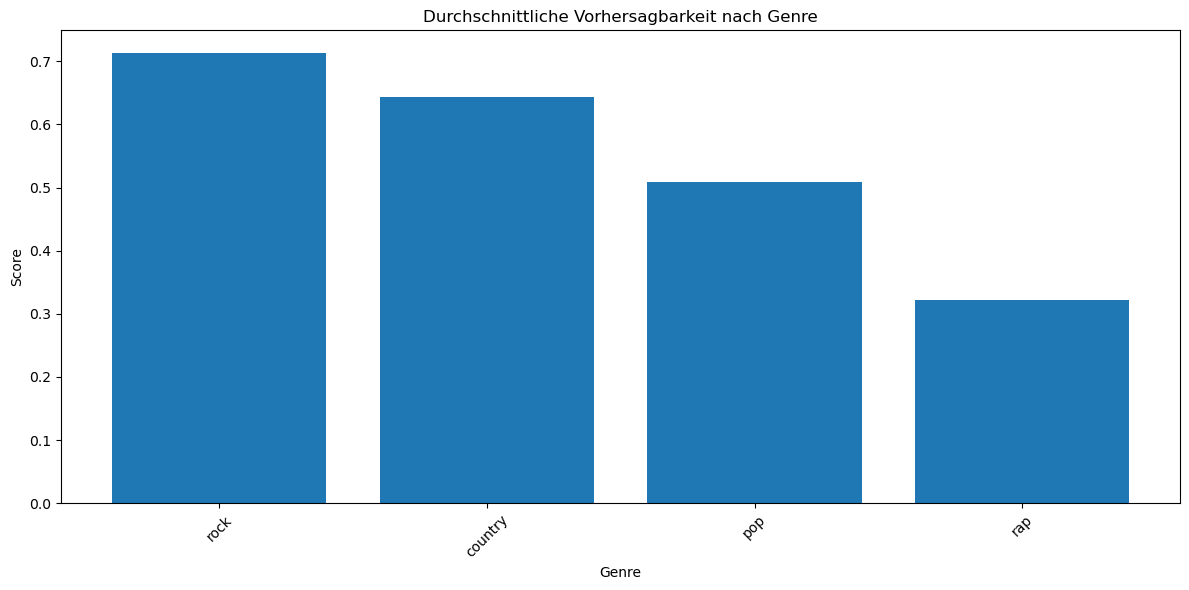

In [52]:
genre_predictability = defaultdict(list)
genres = english_df['tag'].dropna().unique()

for genre in genres:
    genre_songs = english_df[english_df['tag'] == genre].sample(min(20, sum(english_df['tag'] == genre)))
    genre_scores = []
    for _, song in genre_songs.iterrows():
        lines = [line.strip() for line in song['cleaned_lyrics'].split('\n') if len(line.strip()) > 20]
        if not lines:
            continue
        sample_line = random.choice(lines)
        predictability = mlm_analyzer.analyze_predictability(sample_line)
        genre_scores.append(predictability['predictability_score'])
    
    if genre_scores:
        genre_predictability[genre] = genre_scores

# Mittelwerte berechnen und visualisieren
genre_avg = {g: sum(s)/len(s) for g, s in genre_predictability.items()}
sorted_genres = sorted(genre_avg.items(), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(12, 6))
plt.bar([g[0] for g in sorted_genres], [g[1] for g in sorted_genres])
plt.title('Durchschnittliche Vorhersagbarkeit nach Genre')
plt.xlabel('Genre')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Vergleiche Künstler im Genre 'rock':


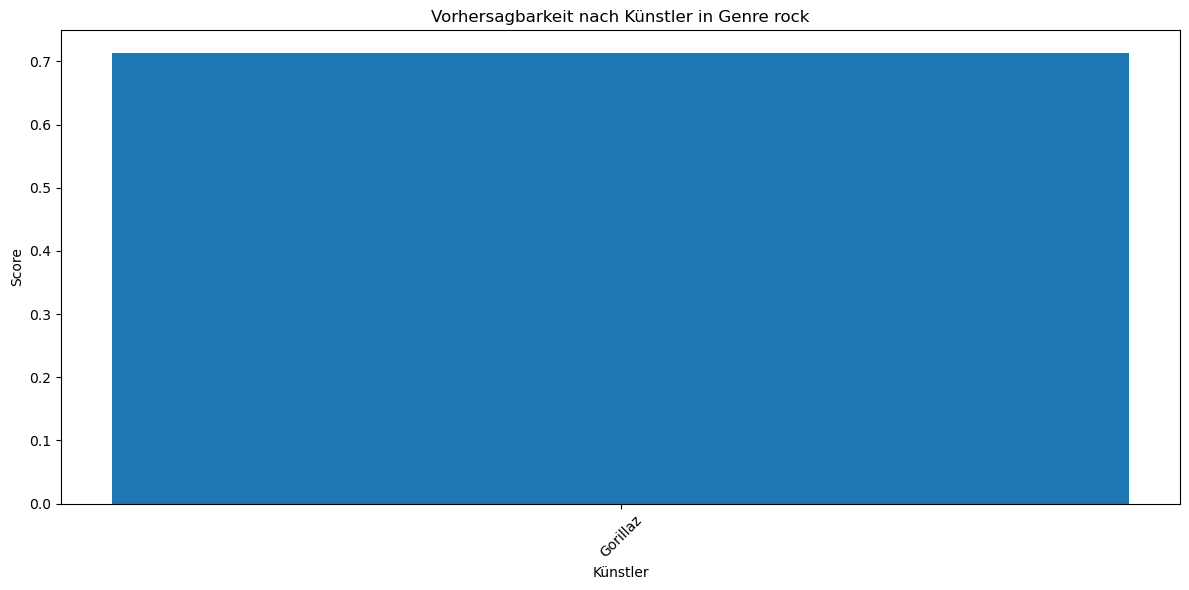

In [53]:
popular_genre = sorted_genres[0][0] if sorted_genres else None
if popular_genre:
    print(f"\nVergleiche Künstler im Genre '{popular_genre}':")
    top_artists = english_df[english_df['tag'] == popular_genre]['artist'].value_counts().head(10).index.tolist()
    
    artist_predictability = defaultdict(list)
    for artist in top_artists:
        artist_songs = english_df[(english_df['tag'] == popular_genre) & (english_df['artist'] == artist)]
        scores = []
        for _, song in artist_songs.iterrows():
            lines = [line.strip() for line in song['cleaned_lyrics'].split('\n') if len(line.strip()) > 20]
            if not lines:
                continue
            sample_line = random.choice(lines)
            predictability = mlm_analyzer.analyze_predictability(sample_line)
            scores.append(predictability['predictability_score'])
        if scores:
            artist_predictability[artist] = sum(scores) / len(scores)
    
    sorted_artists = sorted(artist_predictability.items(), key=lambda x: x[1], reverse=True)

    plt.figure(figsize=(12, 6))
    plt.bar([a[0] for a in sorted_artists], [a[1] for a in sorted_artists])
    plt.title(f'Vorhersagbarkeit nach Künstler in Genre {popular_genre}')
    plt.xlabel('Künstler')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
